7월 30일

In [1]:
#selenium 사용을 위한 library import

from selenium import webdriver as wb
from selenium.webdriver.common.by import By #요소 찾기 
from selenium.webdriver.common.keys import Keys #컴터 키보드

### 1) 키워드 설정 및 기간 설정하기

- f-string : 문자열 앞에 f 를 붙이고, 문자열 내부의 중괄호 안에 변수 표현식을 직접 넣어 사용할 수 있는 문자열 포메팅 방식이다

### 2) 페이지 조회하고, 스크롤 내려보기 

In [40]:
# 1) 브라우저 실행하기 
driver = wb.Chrome()
# 2) 브라우저 창 최대화 하기 
driver.maximize_window()
# 3) 페이지 요청하기
url = 'https://www.wired.com/search/?q=deaf&sort=score+desc'
driver.get(url) 

In [42]:
driver.find_element(By.XPATH,'//*[@id="main-content"]/div[2]/div/div/section[3]/div/div[1]/div/div/div[10]/button/span').click()

NoSuchElementException: Message: no such element: Unable to locate element: {"method":"xpath","selector":"//*[@id="main-content"]/div[2]/div/div/section[3]/div/div[1]/div/div/div[10]/button/span"}
  (Session info: chrome=142.0.7444.162); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#nosuchelementexception
Stacktrace:
0   chromedriver                        0x0000000100d92ecc cxxbridge1$str$ptr + 2941512
1   chromedriver                        0x0000000100d8ab88 cxxbridge1$str$ptr + 2907908
2   chromedriver                        0x00000001008a22b0 _RNvCsgXDX2mvAJAg_7___rustc35___rust_no_alloc_shim_is_unstable_v2 + 74020
3   chromedriver                        0x00000001008e988c _RNvCsgXDX2mvAJAg_7___rustc35___rust_no_alloc_shim_is_unstable_v2 + 366336
4   chromedriver                        0x000000010092ad54 _RNvCsgXDX2mvAJAg_7___rustc35___rust_no_alloc_shim_is_unstable_v2 + 633800
5   chromedriver                        0x00000001008ddef0 _RNvCsgXDX2mvAJAg_7___rustc35___rust_no_alloc_shim_is_unstable_v2 + 318820
6   chromedriver                        0x0000000100d560c8 cxxbridge1$str$ptr + 2692164
7   chromedriver                        0x0000000100d598dc cxxbridge1$str$ptr + 2706520
8   chromedriver                        0x0000000100d3684c cxxbridge1$str$ptr + 2563016
9   chromedriver                        0x0000000100d5a1b4 cxxbridge1$str$ptr + 2708784
10  chromedriver                        0x0000000100d280f4 cxxbridge1$str$ptr + 2503792
11  chromedriver                        0x0000000100d79498 cxxbridge1$str$ptr + 2836500
12  chromedriver                        0x0000000100d7961c cxxbridge1$str$ptr + 2836888
13  chromedriver                        0x0000000100d8a7d8 cxxbridge1$str$ptr + 2906964
14  libsystem_pthread.dylib             0x00000001840a9c08 _pthread_start + 136
15  libsystem_pthread.dylib             0x00000001840a4ba8 thread_start + 8


In [17]:
from selenium import webdriver as wb
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from tqdm import tqdm
import pandas as pd
import time
import re

# ✔ 기사 상세 페이지에서 정보 추출 함수
TITLE_SEL = "#main-content > article > div.ArticlePageLedeBackground-JMVDp.bIwRjk > header > div > div.ContentHeaderHedAccreditationWrapper-WaWBW.jedkOX > div.ContentHeaderTitleBlockWrapper-cyIGwg.iqnUMX.standard > h1"
CONTENT_SEL = "#main-content > article > div.ArticlePageContentBackGround-dcEtzE.kUtTlG.article-body__content"
DATE_SEL = "#main-content > article > div.ArticlePageLedeBackground-JMVDp.bIwRjk > header > div > div.ContentHeaderHedAccreditationWrapper-WaWBW.jedkOX > div.ContentHeaderTitleBlockWrapper-cyIGwg.iqnUMX.standard > div > div.ContentHeaderRubricDateBlock-kvxmSu.hgtOGu > time"
REVIEWS_SEL = "#reviews"


def extract_article(driver, url):
    driver.get(url)
    time.sleep(2)

    article_url = driver.current_url

    # 제목
    try:
        title = driver.find_element(By.CSS_SELECTOR, TITLE_SEL).text.strip()
    except:
        title = ""

    # 본문 (p 태그만)
    try:
        content_block = driver.find_element(By.CSS_SELECTOR, CONTENT_SEL)
        ps = content_block.find_elements(By.TAG_NAME, "p")
        content_list = [p.text.strip() for p in ps if p.text.strip()]
        content = "\n".join(content_list)
    except:
        content = ""

    # 날짜
    try:
        date_el = driver.find_element(By.CSS_SELECTOR, DATE_SEL)
        date_text = date_el.get_attribute("datetime") or date_el.text.strip()
    except:
        date_text = ""

    # 연도 필터링 2020~2025
    match = re.search(r"(20\d{2})", date_text)
    year = int(match.group(1)) if match else None

    if year is None or not (2020 <= year <= 2025):
        return None

    # 댓글
    comments = []
    try:
        reviews = driver.find_element(By.CSS_SELECTOR, REVIEWS_SEL)
        comment_ps = reviews.find_elements(By.TAG_NAME, "p")
        comments = [cp.text.strip() for cp in comment_ps if cp.text.strip()]
    except:
        pass

    return {
        "url": article_url,
        "title": title,
        "content": content,
        "date_raw": date_text,
        "year": year,
        "comments": comments
    }


# ---------------------------------------------
# ✔ MAIN: Wired deaf 검색 전체 크롤링 + CSV까지 저장
# ---------------------------------------------

driver = wb.Chrome()
driver.maximize_window()

START_URL = "https://www.wired.com/search/?q=deaf&sort=score+desc"
LIST_ITEM_LINK_SEL = ".summary-item__content > a"
MORE_BUTTON_SEL = "button.load-more__button"

driver.get(START_URL)
time.sleep(3)

articles = []
seen_urls = set()

max_pages = 20  # More Stories 최대 클릭 횟수

for page in range(1, max_pages + 1):
    print(f"\n=== {page} 페이지 ===")

    # 스크롤로 콘텐츠 로딩 유도
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    time.sleep(2)

    # 기사 목록 기다리기
    try:
        WebDriverWait(driver, 10).until(
            EC.presence_of_all_elements_located((By.CSS_SELECTOR, LIST_ITEM_LINK_SEL))
        )
    except:
        print("기사 블록 로딩 실패. 종료.")
        break

    # 기사 링크 수집
    link_elements = driver.find_elements(By.CSS_SELECTOR, LIST_ITEM_LINK_SEL)

    hrefs = []
    for a in link_elements:
        href = a.get_attribute("href")
        if href and href not in seen_urls:
            seen_urls.add(href)
            hrefs.append(href)

    print("새 URL:", len(hrefs))

    # 상세 페이지 정보 수집
    for href in tqdm(hrefs, desc=f"{page}페이지 기사 수집"):
        data = extract_article(driver, href)
        if data:
            articles.append(data)

    # More 버튼 클릭
    try:
        more_btn = WebDriverWait(driver, 8).until(
            EC.element_to_be_clickable((By.CSS_SELECTOR, MORE_BUTTON_SEL))
        )
        driver.execute_script("arguments[0].click();", more_btn)
        time.sleep(2)
    except:
        print("더 이상 More stories 없음. 종료.")
        break

driver.quit()

print("\n총 수집된 기사 개수:", len(articles))


# ---------------------------------------------
# ✔ CSV 저장
# ---------------------------------------------

df = pd.DataFrame(articles)

# 댓글을 문자열로 합치기
df["comments_joined"] = df["comments"].apply(lambda x: "\n".join(x) if isinstance(x, list) else "")

output_file = "wired_deaf_2020_2025.csv"
df.to_csv(output_file, index=False, encoding="utf-8-sig")

print(f"\nCSV 저장 완료 → {output_file}")
df.head()



=== 1 페이지 ===
새 URL: 24


1페이지 기사 수집: 100%|██████████| 24/24 [04:23<00:00, 10.99s/it]


더 이상 More stories 없음. 종료.

총 수집된 기사 개수: 13

CSV 저장 완료 → wired_deaf_2020_2025.csv


,url,title,content,date_raw,year,comments,comments_joined
0,https://www.wired.com/story/silence-speaks-dea...,This Startup Has Created AI-Powered Signing Av...,MORE THAN 70 million deaf or hard-of-hearing p...,2025-05-07T09:39:49-04:00,2025,[],
1,https://www.wired.com/story/these-translating-...,These Transcribing Eyeglasses Put Subtitles on...,I KNEW THE AI on these smart glasses worked pr...,2025-07-02T07:00:00-04:00,2025,[],
2,https://www.wired.com/story/smartphone-feature...,How to Use Your Smartphone to Cope With Hearin...,All products featured on WIRED are independent...,2025-05-06T10:00:00-04:00,2025,[],
3,https://www.wired.com/story/disinformation-min...,How Disinformation About the Minnesota Shootin...,MINUTES AFTER THE perpetrator of the shooting ...,2025-09-03T11:28:04-04:00,2025,[],
4,https://www.wired.com/story/hear-com-at-home-h...,I Tried Hear.com's At-Home Test for New Prescr...,All products featured on WIRED are independent...,2025-06-19T08:00:00-04:00,2025,[],


- time : 파이썬 내장 모듈, 시간과 다양한 기능을 제공하는 라이브러리 -> time.sleep()
- 웹페이지가 로딩이 아직 되지 않았거나, 동적 콘텐츠가 생성될 때까지 잠시 기다려야 할 때 사용
   - 만약 기다리지 않으면 로딩되지 않은 요소를 찾으려고 하다가 오류 발생 가능 

In [26]:
# 삭제할 컬럼 제거
# df = df.drop(columns=["comments", "comments_joined"])

# 원하는 순서로 재배치
df = df[["title", "content", "date_raw", "url"]]
#date_raw 형식 변경
from datetime import datetime

# df['date_raw'] 컬럼을 YYYY-MM-DD로 변환
df["date"] = df["date_raw"].apply(
    lambda x: datetime.fromisoformat(x).strftime("%Y-%m-%d")
    if isinstance(x, str) and "T" in x
    else x
)

df.head()




,title,content,date_raw,url,date
0,This Startup Has Created AI-Powered Signing Av...,MORE THAN 70 million deaf or hard-of-hearing p...,2025-05-07T09:39:49-04:00,https://www.wired.com/story/silence-speaks-dea...,2025-05-07
1,These Transcribing Eyeglasses Put Subtitles on...,I KNEW THE AI on these smart glasses worked pr...,2025-07-02T07:00:00-04:00,https://www.wired.com/story/these-translating-...,2025-07-02
2,How to Use Your Smartphone to Cope With Hearin...,All products featured on WIRED are independent...,2025-05-06T10:00:00-04:00,https://www.wired.com/story/smartphone-feature...,2025-05-06
3,How Disinformation About the Minnesota Shootin...,MINUTES AFTER THE perpetrator of the shooting ...,2025-09-03T11:28:04-04:00,https://www.wired.com/story/disinformation-min...,2025-09-03
4,I Tried Hear.com's At-Home Test for New Prescr...,All products featured on WIRED are independent...,2025-06-19T08:00:00-04:00,https://www.wired.com/story/hear-com-at-home-h...,2025-06-19


In [27]:
# 삭제할 컬럼 제거
df = df.drop(columns=["date_raw"])
# 원하는 순서로 재배치
df = df[["title", "content", "date", "url"]]


In [29]:
output_file = "aboard_deaf_2025.csv"
df.to_csv(output_file, index=False, encoding="utf-8-sig")

print(f"\nCSV 저장 완료 → {output_file}")
df.head()


CSV 저장 완료 → aboard_deaf_2025.csv


,title,content,date,url
0,This Startup Has Created AI-Powered Signing Av...,MORE THAN 70 million deaf or hard-of-hearing p...,2025-05-07,https://www.wired.com/story/silence-speaks-dea...
1,These Transcribing Eyeglasses Put Subtitles on...,I KNEW THE AI on these smart glasses worked pr...,2025-07-02,https://www.wired.com/story/these-translating-...
2,How to Use Your Smartphone to Cope With Hearin...,All products featured on WIRED are independent...,2025-05-06,https://www.wired.com/story/smartphone-feature...
3,How Disinformation About the Minnesota Shootin...,MINUTES AFTER THE perpetrator of the shooting ...,2025-09-03,https://www.wired.com/story/disinformation-min...
4,I Tried Hear.com's At-Home Test for New Prescr...,All products featured on WIRED are independent...,2025-06-19,https://www.wired.com/story/hear-com-at-home-h...


### 3. a태그에 있는 href 속성을 찾아서, href_list 리스트에 append 하기 

In [6]:
#1. a태그 찾기 
titles = driver.find_elements(By.CSS_SELECTOR, ".summary-item__content > a")
titles


[<selenium.webdriver.remote.webelement.WebElement (session="ba8c4ff40b0e5d39b2b85c4bae1b0744", element="f.19CECFA61D7DA33AF1026ECCA9371077.d.BA174D9A190029B56A6FD89CE05B44FB.e.123")>,
 <selenium.webdriver.remote.webelement.WebElement (session="ba8c4ff40b0e5d39b2b85c4bae1b0744", element="f.19CECFA61D7DA33AF1026ECCA9371077.d.BA174D9A190029B56A6FD89CE05B44FB.e.124")>,
 <selenium.webdriver.remote.webelement.WebElement (session="ba8c4ff40b0e5d39b2b85c4bae1b0744", element="f.19CECFA61D7DA33AF1026ECCA9371077.d.BA174D9A190029B56A6FD89CE05B44FB.e.125")>,
 <selenium.webdriver.remote.webelement.WebElement (session="ba8c4ff40b0e5d39b2b85c4bae1b0744", element="f.19CECFA61D7DA33AF1026ECCA9371077.d.BA174D9A190029B56A6FD89CE05B44FB.e.126")>,
 <selenium.webdriver.remote.webelement.WebElement (session="ba8c4ff40b0e5d39b2b85c4bae1b0744", element="f.19CECFA61D7DA33AF1026ECCA9371077.d.BA174D9A190029B56A6FD89CE05B44FB.e.127")>,
 <selenium.webdriver.remote.webelement.WebElement (session="ba8c4ff40b0e5d39b2b8

In [ ]:
#2. href를  href_list에 append하기 
href_list = []

#href 추출해야함. 
for i in titles:
    href = i.get_attribute('href')
    href_list.append(href)


In [10]:
len(href_list)



24

In [ ]:
from selenium import webdriver as wb
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException, NoSuchElementException
from tqdm import tqdm
import pandas as pd
import time
import re
from datetime import datetime

# -----------------------------
# 0. 설정
# -----------------------------
START_URL = "https://www.wired.com/search/?q=deaf&sort=score+desc"
LIST_ITEM_LINK_SEL = ".summary-item__content > a"   # 검색 결과 기사 링크
MORE_BUTTON_SEL = "button.load-more__button"        # More Stories 버튼

# 기사 상세 페이지 셀렉터
TITLE_SEL = "#main-content > article > div.ArticlePageLedeBackground-JMVDp.bIwRjk > header > div > div.ContentHeaderHedAccreditationWrapper-WaWBW.jedkOX > div.ContentHeaderTitleBlockWrapper-cyIGwg.iqnUMX.standard > h1"
CONTENT_SEL = "#main-content > article > div.ArticlePageContentBackGround-dcEtzE.kUtTlG.article-body__content"
DATE_SEL = "#main-content > article > div.ArticlePageLedeBackground-JMVDp.bIwRjk > header > div > div.ContentHeaderHedAccreditationWrapper-WaWBW.jedkOX > div.ContentHeaderTitleBlockWrapper-cyIGwg.iqnUMX.standard > div > div.ContentHeaderRubricDateBlock-kvxmSu.hgtOGu > time"


# -----------------------------
# 1. More 버튼 강제 클릭 함수
# -----------------------------
def click_more_button(driver):
    """Wired 검색 결과에서 'More Stories' 버튼을 강제로 클릭"""
    try:
        # 버튼이 화면에 들어올 때까지 몇 번 스크롤
        for _ in range(5):
            driver.execute_script("window.scrollBy(0, 1000);")
            time.sleep(0.5)

        # 버튼 나타날 때까지 대기
        more_btn = WebDriverWait(driver, 10).until(
            EC.presence_of_element_located((By.CSS_SELECTOR, MORE_BUTTON_SEL))
        )

        # 클릭 가능한 상태까지 대기
        WebDriverWait(driver, 10).until(
            EC.element_to_be_clickable((By.CSS_SELECTOR, MORE_BUTTON_SEL))
        )

        # JS로 강제 클릭
        driver.execute_script("arguments[0].click();", more_btn)
        print("👉 More 버튼 클릭 성공")
        time.sleep(2.5)
        return True

    except Exception as e:
        print("❌ More 버튼 클릭 실패:", e)
        return False


# -----------------------------
# 2. 기사 상세 페이지에서 정보 추출
# -----------------------------
def extract_article(driver, url):
    """Wired 기사 상세 페이지에서 제목/본문/날짜/URL 가져오기 (2020~2025만)"""
    driver.get(url)
    time.sleep(1.5)

    article_url = driver.current_url

    # 제목
    try:
        title = driver.find_element(By.CSS_SELECTOR, TITLE_SEL).text.strip()
    except:
        title = ""

    # 본문: p 태그만 모아서 합치기 (사진 제외)
    try:
        content_block = driver.find_element(By.CSS_SELECTOR, CONTENT_SEL)
        ps = content_block.find_elements(By.TAG_NAME, "p")
        content_list = [p.text.strip() for p in ps if p.text.strip()]
        content = "\n".join(content_list)
    except:
        content = ""

    # 날짜
    try:
        date_el = driver.find_element(By.CSS_SELECTOR, DATE_SEL)
        date_text = date_el.get_attribute("datetime") or date_el.text.strip()
    except:
        date_text = ""

    # 연도 필터링: 2020~2025만
    match = re.search(r"(20\d{2})", date_text)
    year = int(match.group(1)) if match else None
    if year is None or not (2020 <= year <= 2025):
        return None  # 이 기사 버리기

    return {
        "url": article_url,
        "title": title,
        "content": content,
        "date_raw": date_text,
    }


# -----------------------------
# 3. 1단계: 검색 결과 페이지에서 URL 전부 수집
# -----------------------------
driver = wb.Chrome()
driver.maximize_window()
driver.get(START_URL)
time.sleep(3)

seen_urls = set()
max_more_clicks = 30  # More를 최대 몇 번까지 누를지

for i in range(1, max_more_clicks + 1):
    print(f"\n=== 검색 결과 확장 {i}회차 ===")

    # 화면 맨 아래까지 스크롤해서 새로운 결과 로딩 유도
    last_height = driver.execute_script("return document.body.scrollHeight")
    while True:
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(1)
        new_height = driver.execute_script("return document.body.scrollHeight")
        if new_height == last_height:
            break
        last_height = new_height

    # 현재까지 화면에 로드된 기사 링크들 수집
    try:
        WebDriverWait(driver, 10).until(
            EC.presence_of_all_elements_located((By.CSS_SELECTOR, LIST_ITEM_LINK_SEL))
        )
    except TimeoutException:
        print("기사 링크를 찾지 못했어요. 여기서 종료할게요.")
        break

    link_elements = driver.find_elements(By.CSS_SELECTOR, LIST_ITEM_LINK_SEL)

    before = len(seen_urls)
    for a in link_elements:
        href = a.get_attribute("href")
        if href:
            seen_urls.add(href)
    after = len(seen_urls)

    print(f"현재까지 누적 기사 URL 수: {after} (이번에 새로 추가된 {after - before}개)")

    # More 버튼 클릭 시도
    if not click_more_button(driver):
        print("더 이상 'More stories' 버튼이 없어요. URL 수집 종료!")
        break

href_list = list(seen_urls)
print("\n🌟 최종 수집된 기사 URL 개수:", len(href_list))


# -----------------------------
# 4. 2단계: 수집한 URL 하나씩 방문해서 제목/본문/날짜 수집
# -----------------------------
articles = []

for href in tqdm(href_list, desc="기사 상세 페이지 수집 중"):
    data = extract_article(driver, href)
    if data:
        articles.append(data)

driver.quit()

print("\n✅ 연도 필터(2020~2025) 적용 후 수집된 기사 개수:", len(articles))


# -----------------------------
# 5. DataFrame 정리 + 날짜 포맷 + 컬럼 정렬 + CSV 저장
# -----------------------------
df = pd.DataFrame(articles)

# 날짜 문자열을 YYYY-MM-DD 형식으로 변환
def to_ymd(x):
    if isinstance(x, str):
        try:
            return datetime.fromisoformat(x).strftime("%Y-%m-%d")
        except Exception:
            if len(x) >= 10 and x[4] == "-" and x[7] == "-":
                return x[:10]
    return x

df["date"] = df["date_raw"].apply(to_ymd)

# 안 쓰는 컬럼 정리
df = df.drop(columns=["date_raw"], errors="ignore")

# 컬럼 순서: 제목, 내용, 날짜, URL
df = df[["title", "content", "date", "url"]]

# CSV 저장
output_file = "wired_deaf_2020_2025_final.csv"
df.to_csv(output_file, index=False, encoding="utf-8-sig")

print(f"\n📁 CSV 저장 완료 👉 {output_file}")
df.head()



=== 검색 결과 확장 1회차 ===
현재까지 누적 기사 URL 수: 24 (이번에 새로 추가된 24개)
❌ More 버튼 클릭 실패: Message: 
Stacktrace:
0   chromedriver                        0x0000000101216ecc cxxbridge1$str$ptr + 2941512
1   chromedriver                        0x000000010120eb88 cxxbridge1$str$ptr + 2907908
2   chromedriver                        0x0000000100d262b0 _RNvCsgXDX2mvAJAg_7___rustc35___rust_no_alloc_shim_is_unstable_v2 + 74020
3   chromedriver                        0x0000000100d6d88c _RNvCsgXDX2mvAJAg_7___rustc35___rust_no_alloc_shim_is_unstable_v2 + 366336
4   chromedriver                        0x0000000100daed54 _RNvCsgXDX2mvAJAg_7___rustc35___rust_no_alloc_shim_is_unstable_v2 + 633800
5   chromedriver                        0x0000000100d61ef0 _RNvCsgXDX2mvAJAg_7___rustc35___rust_no_alloc_shim_is_unstable_v2 + 318820
6   chromedriver                        0x00000001011da0c8 cxxbridge1$str$ptr + 2692164
7   chromedriver                        0x00000001011dd8dc cxxbridge1$str$ptr + 2706520
8   chromedriv

기사 상세 페이지 수집 중:   8%|▊         | 2/24 [00:19<03:31,  9.60s/it]


KeyboardInterrupt: 

In [11]:
href_list

['https://www.wired.com/story/silence-speaks-deaf-ai-signing/',
 'https://www.wired.com/story/best-apple-tv-plus-movies/',
 'https://www.wired.com/story/these-translating-ai-glasses-put-subtitles-on-the-world/',
 'https://www.wired.com/sponsored/story/bupa-health-stories/',
 'https://www.wired.com/story/smartphone-features-deaf-hard-of-hearing/',
 'https://www.wired.com/story/disinformation-minnesota-shooting-x/',
 'https://www.wired.com/story/meta-smart-glasses-cognitive-disadvantage/',
 'https://www.wired.com/review/eargo-8-hearing-aids/',
 'https://www.wired.com/story/hear-com-at-home-hearing-test/',
 'https://www.wired.com/story/we-bought-a-peeing-robot-attack-dog-from-temu/',
 'https://www.wired.com/story/what-is-bluetooth/',
 'https://www.wired.com/story/what-lt-col-boz-and-big-techs-enlisted-execs-will-do-in-the-army/',
 'https://www.wired.com/story/apple-and-googles-accessibility-tech-a-sony-xperia-and-huawei-watches-your-gear-news-of-the-week/',
 'https://www.wired.com/story/p

### 4. 접속한 블로그 페이지의 내용 수집하기 

In [17]:
#href_list에 있는 첫번째 블로그 페이지를 요청하기 (get요청,href_list 인덱스)
driver.get(href_list[0])

### 5. 내용 전처리하기

In [31]:
#str.re= place() :문자열에서 특정 문자나 문자열을 다른 문자로 바꿔주는 함수

blog_df['content']= blog_df['content'].str.replace('\n', '')
blog_df['content']
blog_df

,content,date,URL
0,스포츠 러닝 크루에 대한 민폐 논란이 퍼지면서 공지문까지 등장최근 수십 명이 함께 ...,2024. 10. 3. 16:50,https://blog.naver.com/ptj0969/223605587995
1,"“비켜주세요!” 소리에 깜짝 놀란 시민들.“자전거도로까지 점령한 러닝크루, 이래도 ...",2025. 9. 14. 5:00,https://blog.naver.com/soojin3607/224004522474
2,"잊을 만하면 기사에서 한 번씩 언급되는 것이""러닝크루, 민폐"" 키워드 이다.<관련기...",2025. 8. 20. 8:56,https://blog.naver.com/bubbly100/223975992654
3,안녕하세요성실함이 무기인새벽 러너너 미실초이입니다.러닝을 즐기는 사람들이 모여 함께...,2024. 10. 12. 11:10,https://blog.naver.com/rlfehdud/223614070351
4,"러닝크루 가입 전엔 이랬죠.“와, 매주 같이 달리면 꾸준히 할 수 있겠는데?”“재밌...",2025. 7. 5. 23:56,https://blog.naver.com/allaboutsafety_/2239232...
...,...,...,...
134,오늘은 대한민국의 배우 진태현에 대해 살펴보겠습니다.진태현은 본명 김태현으로 198...,2025. 7. 27. 23:31,https://blog.naver.com/add-post/223949156233
135,대한민국에서는 러닝 열풍이 거세게 불고 있습니다.주말마다 한강과 도심 곳곳에서 러닝...,2025. 6. 15. 9:43,https://blog.naver.com/kimnotee/223899701542
136,러닝크루 민폐 논란 확산<쉬운 버전>코로나19 유행이 시작되면서 실외운동 인기가 굉...,2025. 2. 10. 12:38,https://blog.naver.com/rcy419/223755134557
137,"안녕하세요, 넥스트 브리프의 윤슬입니다! 😊 최근 ""울면서 회사 안 다니려면 부동산...",2025. 5. 15. 18:34,https://blog.naver.com/zoo_dragon/223866775154


### 내용 저장하기

In [33]:
# 문자열 포매팅 방식 사용하기 : .format()활용햐보가
#csv 파일로 저장하기 : to_csv
import pandas as pd 

blog_df.to_csv("러닝크루_민폐.csv",encoding = 'utf-8-sig')

### 7. 워드클라우드 만들기 
1. 명사추출함수 정의하기 
2. 명사 리스트 추출(apply)
3. 단어별 빈도 계산기 (counter)
4. 워드클라우드 그려보기 (WordCloud,plt)

In [34]:
from konlpy.tag import Okt


In [35]:
# 1. 명사 추출 함수 정의하기
okt = Okt()

def extract_nouns(text):
    # 1) tag값이 'Noun'이고, len(word) >=2 것들만 반환하기
    # nouns 리스트에 append (조건을 만족하면)
    nouns = []
    
    # pos로 결과 값을 받아보면 : (단어, 품사)
    for word, tag in okt.pos(text):
        if tag == "Noun" and len(word) >= 2:
            nouns.append(word)
    return nouns

In [36]:
#2. 명사 리스트 추출
blog_df["nouns"] = blog_df["content"].apply(extract_nouns)
blog_df

,content,date,URL,nouns
0,스포츠 러닝 크루에 대한 민폐 논란이 퍼지면서 공지문까지 등장최근 수십 명이 함께 ...,2024. 10. 3. 16:50,https://blog.naver.com/ptj0969/223605587995,"[스포츠, 러닝, 크루, 대한, 민폐, 논란, 지문, 등장, 최근, 수십, 스포츠,..."
1,"“비켜주세요!” 소리에 깜짝 놀란 시민들.“자전거도로까지 점령한 러닝크루, 이래도 ...",2025. 9. 14. 5:00,https://blog.naver.com/soojin3607/224004522474,"[소리, 깜짝, 놀란, 시민, 자전거, 도로, 점령, 러닝, 크루, 건강, 운동, ..."
2,"잊을 만하면 기사에서 한 번씩 언급되는 것이""러닝크루, 민폐"" 키워드 이다.<관련기...",2025. 8. 20. 8:56,https://blog.naver.com/bubbly100/223975992654,"[만하, 기사, 언급, 러닝, 크루, 민폐, 워드, 관련, 기사, 아이스박스, 음료..."
3,안녕하세요성실함이 무기인새벽 러너너 미실초이입니다.러닝을 즐기는 사람들이 모여 함께...,2024. 10. 12. 11:10,https://blog.naver.com/rlfehdud/223614070351,"[무기, 새벽, 러너, 미실, 초이, 러닝, 사람, 러닝, 크루, 활동, 통해, 건..."
4,"러닝크루 가입 전엔 이랬죠.“와, 매주 같이 달리면 꾸준히 할 수 있겠는데?”“재밌...",2025. 7. 5. 23:56,https://blog.naver.com/allaboutsafety_/2239232...,"[러닝, 크루, 가입, 달리, 사람, 막상, 달리기, 사람, 경험, 활용, 오늘, ..."
...,...,...,...,...
134,오늘은 대한민국의 배우 진태현에 대해 살펴보겠습니다.진태현은 본명 김태현으로 198...,2025. 7. 27. 23:31,https://blog.naver.com/add-post/223949156233,"[오늘, 대한민국, 배우, 진태현, 대해, 진태현, 본명, 김태현, 서울특별시, 연..."
135,대한민국에서는 러닝 열풍이 거세게 불고 있습니다.주말마다 한강과 도심 곳곳에서 러닝...,2025. 6. 15. 9:43,https://blog.naver.com/kimnotee/223899701542,"[대한민국, 러닝, 열풍, 거세, 주말, 한강, 도심, 곳곳, 러닝, 사람, 거리,..."
136,러닝크루 민폐 논란 확산<쉬운 버전>코로나19 유행이 시작되면서 실외운동 인기가 굉...,2025. 2. 10. 12:38,https://blog.naver.com/rcy419/223755134557,"[러닝, 크루, 민폐, 논란, 확산, 버전, 코로나, 유행, 시작, 실외, 운동, ..."
137,"안녕하세요, 넥스트 브리프의 윤슬입니다! 😊 최근 ""울면서 회사 안 다니려면 부동산...",2025. 5. 15. 18:34,https://blog.naver.com/zoo_dragon/223866775154,"[넥스트, 브리프, 윤슬, 최근, 울면, 회사, 부동산, 장해, 자극, 이야기, 크..."


In [37]:
#3. 단어별 빈도 계산하기 (Counter)
from collections import Counter

all_nouns = []

#df["nouns"] 열에 있는 명사들을 하나씩 꺼내서 all_nouns 리스트에 추가할 것임 
for nouns in blog_df["nouns"]:
    all_nouns.extend(nouns)
    #extend : 여러 요소를 한번에 기존 리스트에 추가할 때 사용함 
    #append() 리스트 전체를 하나의 요소로 추가함, extend는 각 요소를 풀어서 하나씩 리스트에 이어 붙임. 

In [38]:
freq_dict = Counter(all_nouns)

In [39]:
#상이ㅜ 10개 단어 및 빈도 계산하기 
top10 = freq_dict.most_common(10)
top10

[('러닝', 1715),
 ('크루', 1093),
 ('사람', 443),
 ('달리기', 416),
 ('민폐', 322),
 ('운동', 314),
 ('공원', 214),
 ('이상', 192),
 ('단체', 192),
 ('문화', 183)]

In [48]:
#불용어 처리 : '음식물', '처리기' 
stopwords = ["러닝","크루"]

#새로운 필터링된 리스트 생성을 위한 빈 리스트
filtered_nouns = []

for nouns in all_nouns:
    #들어온 명사가 stopwords가 아니라면 , filtered_nouns에 append
    if nouns not in stopwords:
        filtered_nouns.append(nouns)

filtered_nouns

['스포츠',
 '대한',
 '민폐',
 '논란',
 '지문',
 '등장',
 '최근',
 '수십',
 '스포츠',
 '유행',
 '소음',
 '통행',
 '방해',
 '불편',
 '호소',
 '시민',
 '논란',
 '상황',
 '서울',
 '서초구',
 '반포',
 '종합',
 '운동장',
 '이상',
 '단체',
 '달리기',
 '제한',
 '송파구',
 '석촌호수',
 '산책로',
 '이상',
 '달리기',
 '자제',
 '성북구',
 '달리기',
 '현수막',
 '각각',
 '서초구',
 '서울',
 '송파구',
 '석촌호수',
 '산책로',
 '이상',
 '자제',
 '요청',
 '내용',
 '현수막',
 '상태',
 '서울',
 '성북구',
 '우측',
 '보행',
 '달리기',
 '현수막',
 '경기',
 '화성시',
 '동탄',
 '호수',
 '공원',
 '산책로',
 '출입',
 '자제',
 '권고',
 '최근',
 '세대',
 '중심',
 '유행',
 '번지',
 '일부',
 '무리',
 '사진',
 '이유',
 '인도',
 '도로',
 '행위',
 '민폐',
 '논란',
 '일부',
 '공용',
 '사용',
 '체육',
 '시설',
 '장악',
 '다른',
 '시민',
 '이용',
 '불편',
 '초래',
 '해당',
 '사례',
 '시민',
 '민원',
 '지자체',
 '단체',
 '이용',
 '제한',
 '운동',
 '문화',
 '정착',
 '위해',
 '서로',
 '대한',
 '배려',
 '바탕',
 '목소리',
 '출처',
 '뉴스',
 '단체',
 '스포츠인',
 '관련',
 '민폐',
 '논란',
 '일면',
 '지자체',
 '달리기',
 '제한',
 '현수막',
 '증가',
 '다른',
 '일부',
 '사람',
 '사진',
 '이유',
 '인도',
 '도로',
 '공용',
 '체육',
 '시설',
 '장악',
 '민폐',
 '행위',
 '경우',
 '모양',
 '서초구',
 '송파구',
 '성북구',
 '저런',
 '단체',


In [49]:
freq_dict = Counter(filtered_nouns)

top10 = freq_dict.most_common(10)
top10

[('사람', 443),
 ('달리기', 416),
 ('민폐', 322),
 ('운동', 314),
 ('공원', 214),
 ('이상', 192),
 ('단체', 192),
 ('문화', 183),
 ('활동', 182),
 ('시민', 173)]

In [50]:
#워드클라우드 그리기 위한 library import 하기 
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [51]:
#워드클라우드 객체 만들기
wc = WordCloud(
    font_path ='C:/Windows/Fonts/malgunbd.ttf',
    background_color = 'white',
    width = 800,
    height = 600
).generate_from_frequencies(dict(freq_dict))
#generate_from_frequencies() :단어-빈도 딕셔너리를 바탕으로 워드클라우드를 생성해주는 함수
#freq_dict :(단어, 빈도) 쌍으로 있는 Counter 객체 -> 딕셔너리 형태로 변환이 필요하다 

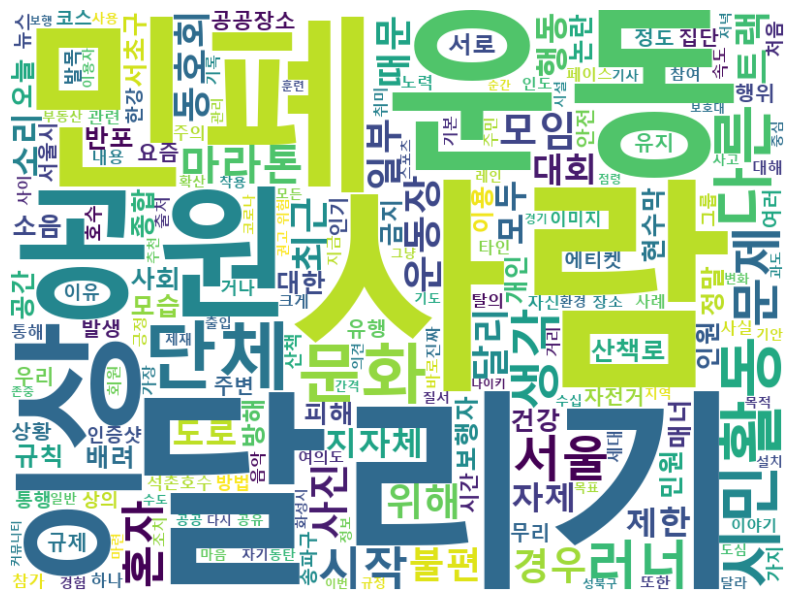

In [52]:
#워드클라우드 이미지 표시하기
plt.figure(figsize = (10,8))
plt.imshow(wc, interpolation = 'bilinear')
plt.axis('off')
plt.show()